<a href="https://colab.research.google.com/github/PolarBear-289/Time-series-data-prediction-using-gluonTS/blob/main/Gluon_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gluonts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 


In [ ]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 145 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [ ]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [ ]:
dataset = get_dataset("m4_hourly")

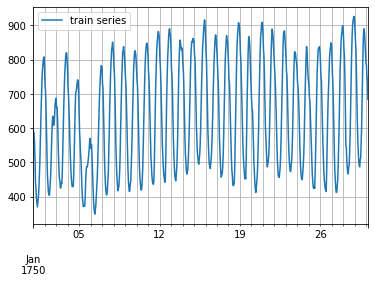

In [ ]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

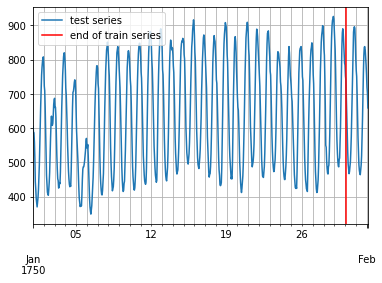

In [ ]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [ ]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [ ]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [ ]:
from gluonts.dataset.common import ListDataset

In [ ]:
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

In [ ]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [ ]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [ ]:
predictor = estimator.train(dataset.train)


100%|██████████| 100/100 [00:03<00:00, 29.17it/s, epoch=5/5, avg_epoch_loss=4.77]


In [ ]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
ts_entry = tss[0]

In [ ]:
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [ ]:
dataset_test_entry = next(iter(dataset.test))

In [ ]:
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [ ]:
forecast_entry = forecasts[0]

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [630.9687  589.92645 503.09296 525.04956 472.94247 486.47937 449.0677
 454.0277  510.28137 522.12573 594.9323  647.2693  768.9918  791.33923
 904.16656 962.00476 897.54987 879.5048  847.96564 878.7092  850.5058
 803.7285  768.2363  715.8915  625.1338  534.2089  535.6366  405.7589
 497.66837 450.81384 416.93427 543.04346 571.64874 509.8656  644.31915
 827.6113  805.08954 856.9525  899.61383 756.729   927.47736 856.416
 921.90845 851.6665  948.38794 731.1396  773.1078  802.04224]
0.5-quantile (median) of the future window:
 [639.4992  578.6728  515.59753 526.22626 459.05765 487.74075 464.93832
 457.7464  512.7079  508.33926 597.5918  640.93805 781.7536  806.3454
 902.68555 985.698   909.53906 885.754   845.57495 866.0106  859.4306
 789.6933  761.20306 695.9465  630.5711  541.9498  544.828   415.9823
 506.38092 458.2016  411.11923 536.50037 562.80676 507.2116  636.2417
 819.76965 794.2844  841.4762  903.311   776.8637  931.68115 861.2748
 920.3795  820.50507 92

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

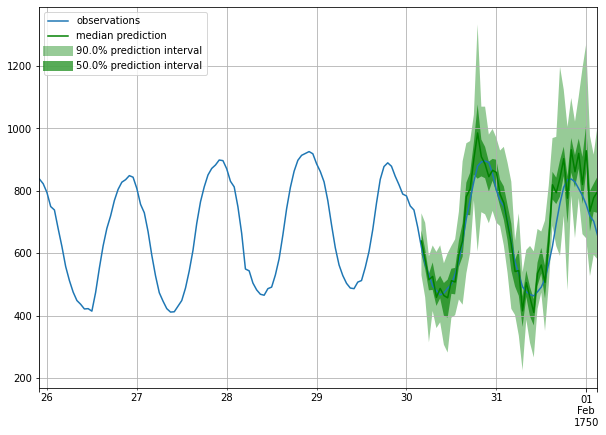

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)


Running evaluation: 414it [00:00, 6599.05it/s]


In [ ]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 14155257.189498072,
    "abs_error": 10856130.670635223,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.322091272750727,
    "MAPE": 0.26425296327342157,
    "sMAPE": 0.19702085093167668,
    "MSIS": 59.191509797078105,
    "QuantileLoss[0.1]": 5030548.1339265825,
    "Coverage[0.1]": 0.1272644927536232,
    "QuantileLoss[0.5]": 10856130.59749794,
    "Coverage[0.5]": 0.5285829307568437,
    "QuantileLoss[0.9]": 6844672.8189994795,
    "Coverage[0.9]": 0.8743458132045088,
    "RMSE": 3762.347297831245,
    "NRMSE": 0.513643509255201,
    "ND": 0.07458240880814597,
    "wQuantileLoss[0.1]": 0.03456023226290208,
    "wQuantileLoss[0.5]": 0.0745824083056875,
    "wQuantileLoss[0.9]": 0.047023401047065115,
    "mean_absolute_QuantileLoss": 7577117.183474667,
    "mean_wQuantileLoss": 0.05205534720521823,
    "MAE_Coverage": 0.027167203435319382,
    "OWA": NaN
}


In [ ]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4626.708984,2311.988770,31644.0,659.250000,42.371302,1.136770,0.072746,0.069662,0.073062,12.807829,1035.859308,0.062500,2311.988922,0.687500,1413.587524,1.000000
1,1.0,201136.020833,18701.996094,124149.0,2586.437500,165.107988,2.359819,0.151147,0.137594,0.150642,14.395345,6085.535132,0.333333,18701.994629,1.000000,8142.537207,1.000000
2,2.0,30731.593750,6537.587402,65030.0,1354.791667,78.889053,1.726472,0.091933,0.097523,0.100532,12.260490,3215.566321,0.000000,6537.587280,0.166667,2377.269507,0.791667
3,3.0,247941.687500,17849.609375,235783.0,4912.145833,258.982249,1.435878,0.075364,0.074847,0.075704,13.630446,9292.486279,0.062500,17849.608643,0.458333,8662.832471,0.958333
4,4.0,130375.666667,13126.176758,131088.0,2731.000000,200.494083,1.363941,0.098347,0.091750,0.100133,11.635366,5660.074780,0.125000,13126.176636,0.687500,7087.572925,1.000000


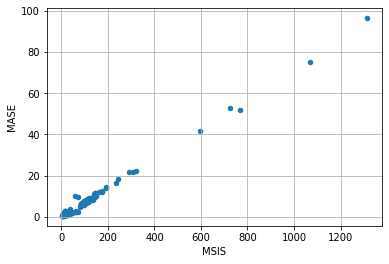

In [ ]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()